# Intro to Random Forests

Solution to Bulldozers Competition using TensorFlow implementation of Random Forests.

In [53]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import forest, RandomForestClassifier, RandomForestRegressor
import scipy
import utils
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1
Preprocess Training Data from csv file.

In [2]:
df_raw = pd.read_csv('./Train/Train.csv', low_memory = False, parse_dates = ["saledate"])
df_raw.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The SalePrice is the value to be predicted. The RMS of Log value will be calculated. Therefore it would be wise to convert SalePrice to log value beforehand.

In [3]:
df_raw.SalePrice = np.log(df_raw.SalePrice)


The SaleDate column contains dates of the sale. We can add addition columns to the dataframe like day of week, day of month, etc. The age of bulldozer should also be considered a good feature, so we get it by subtracting sale year from the year made in.

In [4]:
utils.add_datepart(df_raw, 'saledate')
df_raw['age'] = df_raw['saleYear'] - df_raw['YearMade']
df_raw.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,11.0974,10.9508,9.21034,10.5584,9.30565
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
fiModelDesc,521D,950FII,226,PC120-6E,S175


Now we check Data Types of columns. Since we have both numerical and non-numerical data, we have to convert non-numerical data to numerical data for making random forest.

In [5]:
df_raw.dtypes

SalesID                       int64
SalePrice                   float64
MachineID                     int64
ModelID                       int64
datasource                    int64
auctioneerID                float64
YearMade                      int64
MachineHoursCurrentMeter    float64
UsageBand                    object
fiModelDesc                  object
fiBaseModel                  object
fiSecondaryDesc              object
fiModelSeries                object
fiModelDescriptor            object
ProductSize                  object
fiProductClassDesc           object
state                        object
ProductGroup                 object
ProductGroupDesc             object
Drive_System                 object
Enclosure                    object
Forks                        object
Pad_Type                     object
Ride_Control                 object
Stick                        object
Transmission                 object
Turbocharged                 object
Blade_Extension             

It can be seen that the non-numerical data is stored as object data-type, we can convert these to categorical and map the categorical data to codes using pandas.

In [6]:
utils.train_cats(df_raw)

Now it's time to check for and fix missing data.

In [7]:
print("Total no. of rows = "+ str(len(df_raw)))
df_raw.isnull().sum()

Total no. of rows = 401125


SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    258360
UsageBand                   331486
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             137191
fiModelSeries               344217
fiModelDescriptor           329206
ProductSize                 210775
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                296764
Enclosure                      325
Forks                       209048
Pad_Type                    321991
Ride_Control                252519
Stick                       321991
Transmission                217895
Turbocharged                321991
Blade_Extension             375906
Blade_Width         

It can be seen that there is a lot of missing data in some columns. We will now replace missing data by median can create new columns of booleans to specify whether data was missing or not. The categorical data will be replaced by category codes.

In [8]:
df, y, nas = utils.proc_df(df_raw, 'SalePrice')
df.dtypes

SalesID                          int64
MachineID                        int64
ModelID                          int64
datasource                       int64
auctioneerID                   float64
YearMade                         int64
MachineHoursCurrentMeter       float64
UsageBand                         int8
fiModelDesc                      int16
fiBaseModel                      int16
fiSecondaryDesc                  int16
fiModelSeries                     int8
fiModelDescriptor                int16
ProductSize                       int8
fiProductClassDesc                int8
state                             int8
ProductGroup                      int8
ProductGroupDesc                  int8
Drive_System                      int8
Enclosure                         int8
Forks                             int8
Pad_Type                          int8
Ride_Control                      int8
Stick                             int8
Transmission                      int8
Turbocharged             

Now the training data is split into a training set and a cross-validation set. Generally 70-30 ratio is used but in case of large dataset only a small sample can be used for cross-validation.

In [9]:
 X_train, X_dev = utils.split_vals(df,max_dev = 12000)
Y_train, Y_dev = utils.split_vals(y, max_dev = 12000)
X_train.shape, X_dev.shape, Y_train.shape, Y_dev.shape

((389125, 67), (12000, 67), (389125,), (12000,))

## The Random Forest
Now we implement the random forest using scikit-learn on train set and check for scores on dev set.
We will use 40 decision tree with 3 rows on each leaf.
Every tree will use maximum of half of the features. This reduces overfitting.
OOB score represents average of scores of decision trees on which each individual row was not trained.

In [12]:
utils.set_rf_samples(50000)
def print_score(m):
    res = [utils.rmse(m.predict(X_train), Y_train), utils.rmse(m.predict(X_dev), Y_dev),
                m.score(X_train, Y_train), m.score(X_dev, Y_dev)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    

m = RandomForestRegressor(n_estimators=50,min_samples_leaf=3,max_features=0.6,n_jobs=-1,oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

[0.20405829836004147, 0.24729087699459626, 0.9129751371336015, 0.890789558328821, 0.8956980548361952]


A low value of rmse is reached. Now we can do feature engineering on the data to further improve our algorithm.

## Feature Importance
Now we see the most important features which decide the output.

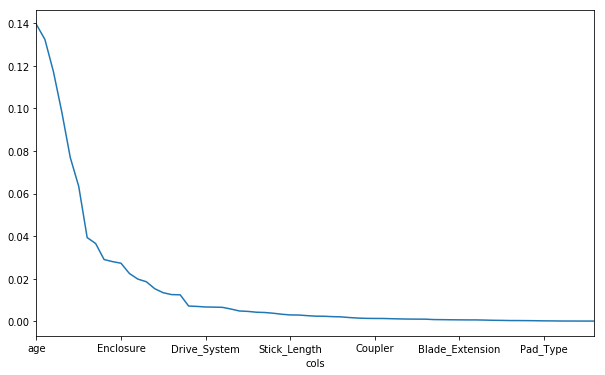

In [18]:
fi = utils.rf_feat_importance(m, X_train)
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

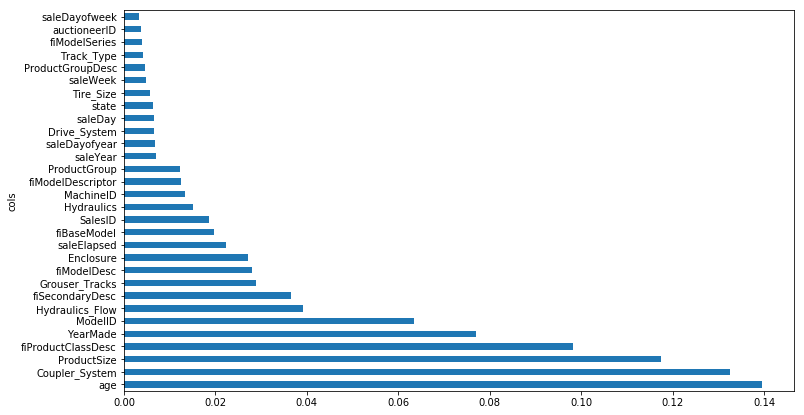

In [19]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [20]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [22]:
df_keep = df[to_keep].copy()
X_train, X_dev = utils.split_vals(df_keep, max_dev = 12000)

In [24]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

[0.2064012808641687, 0.24501536973989066, 0.910965237980178, 0.8927901642271279, 0.8944995993907854]


It can be seen that OOB and Dev set accuracy is improved by removing less important features.

## One hot encoding
Until now all categories were turned to numerical data, which makes it harder for decision tree to make splits.
We can implement one-hot encoding for categorical data with less number of categories.

In [28]:
df_trn2, y_trn, nas = utils.proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_dev = utils.split_vals(df_trn2, max_dev = 12000)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

[0.20709381232714855, 0.2583822247408741, 0.9103667647964951, 0.8807733776804102, 0.8926201094090944]


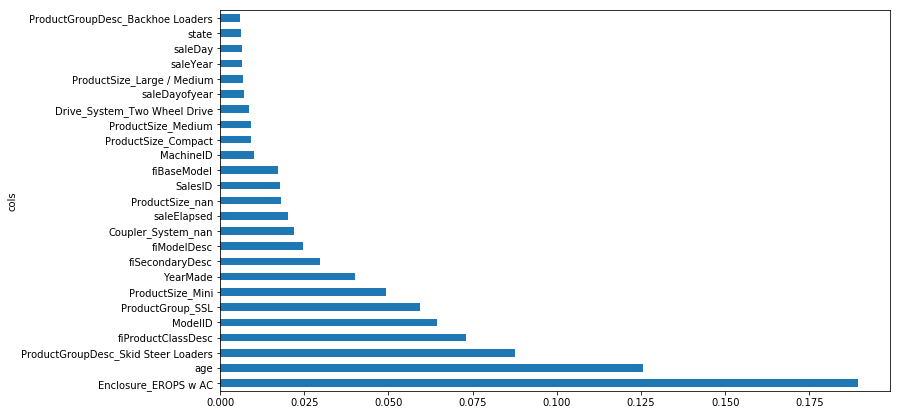

In [30]:
fi = utils.rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

## Removing Redundant features

One thing that makes it harder to interpret is that there seem to be more variables with very similar meanings. Lets try to remove redundant features.

In [31]:
from scipy.cluster import hierarchy as hc

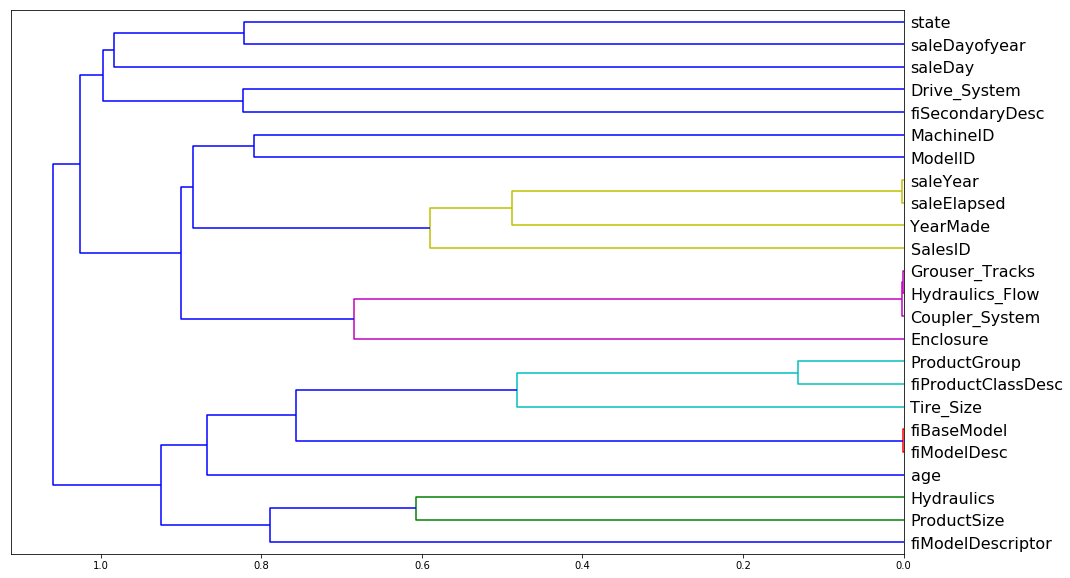

In [36]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Lets try removing some of these features and see if model will be impacted without affecting accuracy.

In [44]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = utils.split_vals(df, max_dev = 12000)
    m.fit(x, Y_train)
    return m.oob_score_

In [45]:
get_oob(df_keep)

0.8906736622824666

Now we try removing each of the closely related features one at a time.

In [46]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Hydraulics_Flow'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8903471686821515
saleElapsed 0.8887073832056129
fiModelDesc 0.8889405791114169
fiBaseModel 0.8900170110838413
Grouser_Tracks 0.8909393056747672
Hydraulics_Flow 0.8905738184505289


We can remove one feature from each group.

In [47]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8896514154386453

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.



In [50]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_dev = utils.split_vals(df_keep, max_dev = 12000)

In [54]:
utils.reset_rf_samples()

In [55]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

[0.12524671822857517, 0.2268500594140524, 0.9672155776237438, 0.9080978294527754, 0.9085810139235286]


The accuracy has greatly improved as it can be seen by rmse and accuracy.

## Partial Dependence

In [56]:
from pdpbox import pdp
from plotnine import *

In [57]:
utils.set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [62]:
df_trn2, y_trn, nas = utils.proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_dev = utils.split_vals(df_trn2, max_dev = 12000)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, Y_train);

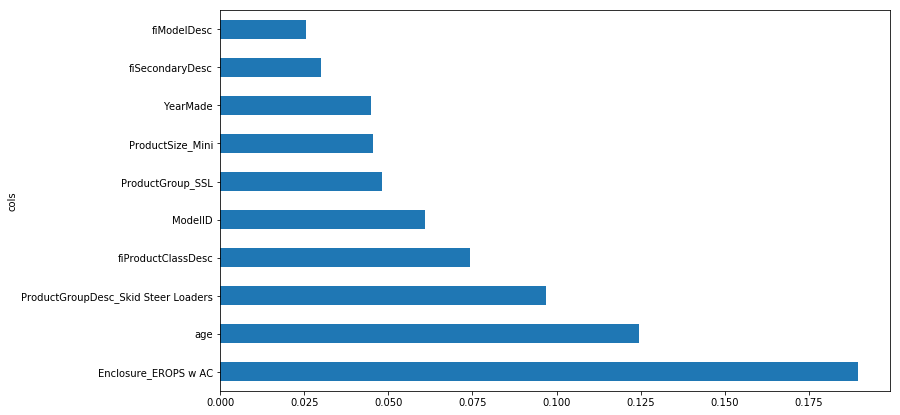

In [64]:
plot_fi(utils.rf_feat_importance(m, df_trn2)[:10]);

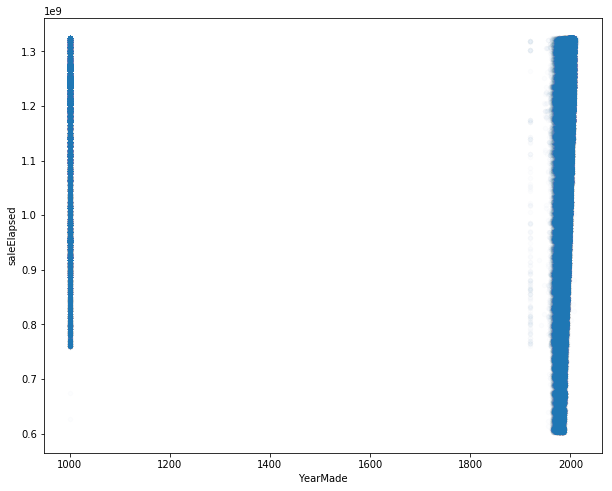

In [65]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

It can be seen that there is high correlation b/w year-made and sale-elapsed.

In [67]:
x_all = utils.get_sample(df_raw[df_raw.YearMade>1930], 500)

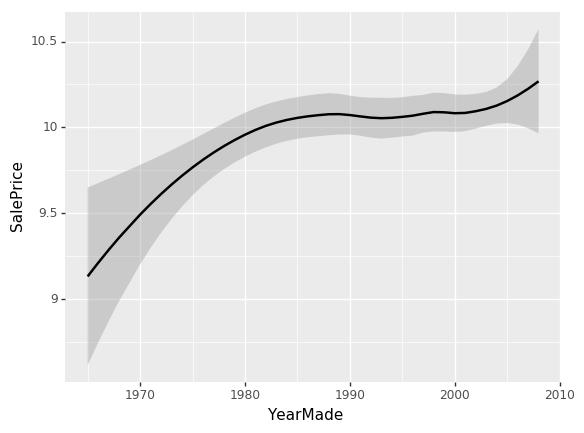

<ggplot: (146711896412)>

In [70]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [71]:
x = utils.get_sample(X_train[X_train.YearMade>1930], 500)

In [78]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, X_train.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2228b4e2400>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2228b4f64a8>})

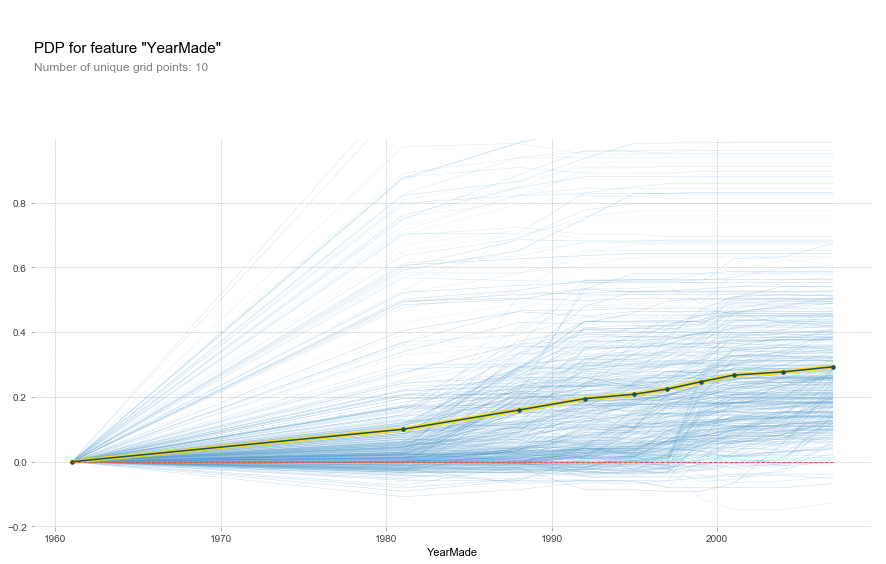

In [79]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x22286af9e48>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2228616ef60>})

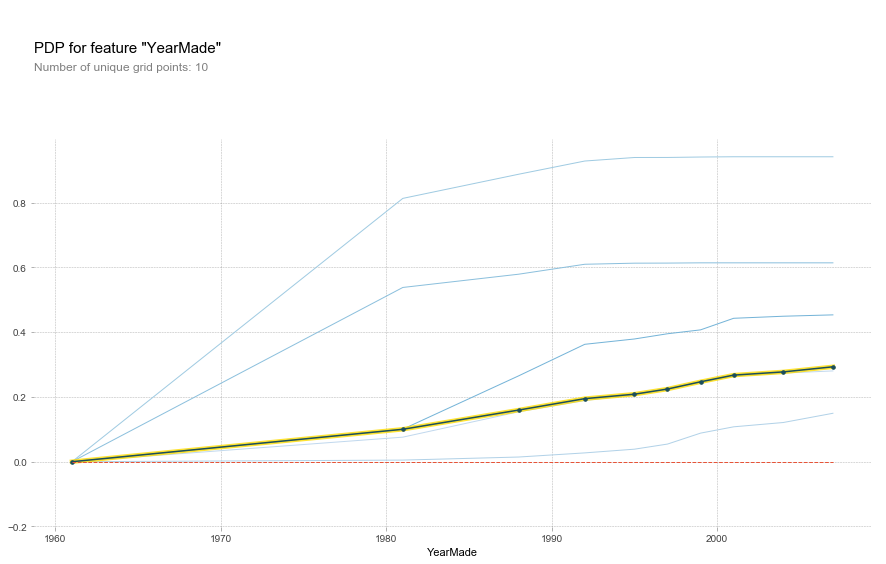

In [80]:
plot_pdp('YearMade', clusters=5)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x22288bad6d8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x22288d5b908>})

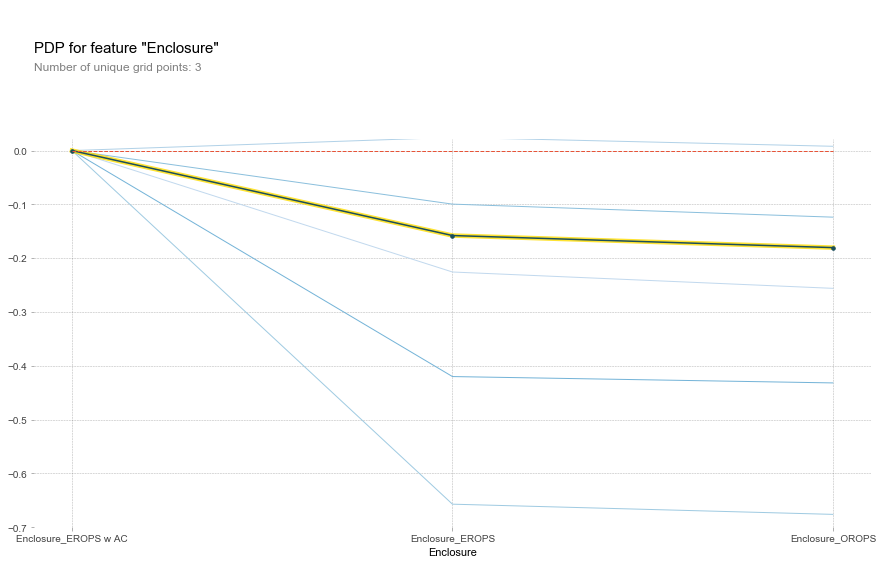

In [86]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [87]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

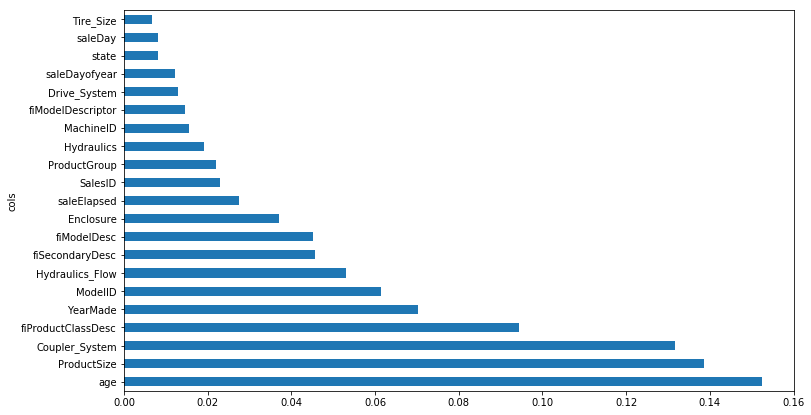

In [91]:
X_train, X_dev = utils.split_vals(df_keep, max_dev = 12000)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, Y_train)
plot_fi(utils.rf_feat_importance(m, df_keep));

## Tree Interpreter

In [92]:
from treeinterpreter import treeinterpreter as ti

In [95]:
df_train, df_valid = utils.split_vals(df_raw[df_keep.columns], max_dev = 12000)

In [98]:
row = X_dev.values[None,0]; row

array([[        11,          0,          5,         17,       1999,
               665,          0,          0,       3232,          1,
        1284595200,    4364751,         12,    2300944,          0,
                 4,        259,          0,         16,         35,
                 0]], dtype=int64)

In [99]:
prediction, bias, contributions = ti.predict(m, row)

In [100]:
prediction[0], bias[0]

(array([9.29167126]), 10.105846470994546)

In [101]:
idxs = np.argsort(contributions[0])

In [102]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5070501942945922),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.13758011271989457),
 ('age', 11, -0.13167619229479452),
 ('fiSecondaryDesc', nan, -0.06487849765439524),
 ('fiModelDesc', 'KX1212', -0.061496587009759504),
 ('MachineID', 2300944, -0.04135390916588211),
 ('Enclosure', 'EROPS', -0.03651258797403765),
 ('fiModelDescriptor', nan, -0.03169293432407381),
 ('saleDayofyear', 259, -0.030389742400611874),
 ('saleDay', 16, -0.01032237526539168),
 ('saleElapsed', 1284595200, -0.004875672735526804),
 ('Tire_Size', nan, -0.0018883943292036243),
 ('state', 'Ohio', 0.0004581653544696973),
 ('Drive_System', nan, 0.006595267392129634),
 ('ProductGroup', 'TEX', 0.010238216208915362),
 ('SalesID', 4364751, 0.010933240151172762),
 ('Hydraulics', 'Standard', 0.012217189580806398),
 ('ModelID', 665, 0.02026416497929886),
 ('Hydraulics_Flow', nan, 0.023542290035737424),
 ('Coupler_System', nan, 0.06314917045746946),
 ('YearMade

In [103]:
contributions[0].sum()

-0.8141752124367072

## Extrapolation

In [106]:
df_ext = df_keep.copy()
n_trn = df_ext.shape[0] - 12000
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = utils.proc_df(df_ext, 'is_valid')

In [107]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999800560922406

In [109]:
fi = utils.rf_feat_importance(m, x); fi[:10]

,cols,imp
11,SalesID,0.749755
10,saleElapsed,0.155366
13,MachineID,0.079160
4,YearMade,0.002504
8,fiModelDesc,0.002423
16,saleDayofyear,0.002413
5,ModelID,0.002402
9,Enclosure,0.001674
12,Hydraulics,0.001359
1,Coupler_System,0.000825


In [110]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [111]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [112]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [113]:
x.drop(feats, axis=1, inplace=True)

In [114]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9788494858211281

In [116]:
fi = utils.rf_feat_importance(m, x); fi[:10]

,cols,imp
0,age,0.236179
4,YearMade,0.189207
13,saleDayofyear,0.154296
5,ModelID,0.080128
8,fiModelDesc,0.062169
15,saleDay,0.057538
16,state,0.056741
3,fiProductClassDesc,0.032903
7,fiSecondaryDesc,0.025291
9,Enclosure,0.021137


In [118]:
utils.set_rf_samples(50000)

In [119]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [122]:
X_train, X_dev = utils.split_vals(df_keep, max_dev = 12000)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

[0.20795909876605384, 0.24772740606525986, 0.9096161827230955, 0.8904036515705106, 0.8931309654345005]


In [126]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_dev = utils.split_vals(df_subs, max_dev = 12000)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, Y_train)
    print(f)
    print_score(m)

SalesID
[0.20899111216727484, 0.24493061146746123, 0.9087168832047062, 0.8928643256869256, 0.8925673033667173]
saleElapsed
[0.2129851047586803, 0.25344022444589676, 0.9051945530941725, 0.8852905855040919, 0.8881842997835634]
MachineID
[0.20638727412806654, 0.24642930597295973, 0.9109773216658569, 0.8915492195172382, 0.8952271516764039]
age
[0.20896950229809325, 0.24883675262831093, 0.908735759741673, 0.8894198883409546, 0.8920849283904618]
YearMade
[0.20860037544162932, 0.25215522648069477, 0.9090578960168495, 0.8864508408328357, 0.8924554905830558]
saleDayofyear
[0.20843256683226105, 0.24359655879271436, 0.9092041539482282, 0.8940282096245161, 0.8931591474704602]


In [128]:
utils.reset_rf_samples()

In [131]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_dev = utils.split_vals(df_subs, max_dev = 12000)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

[0.13757091828515425, 0.21801633107809418, 0.9604462104506333, 0.9151159626982214, 0.9090732218133432]


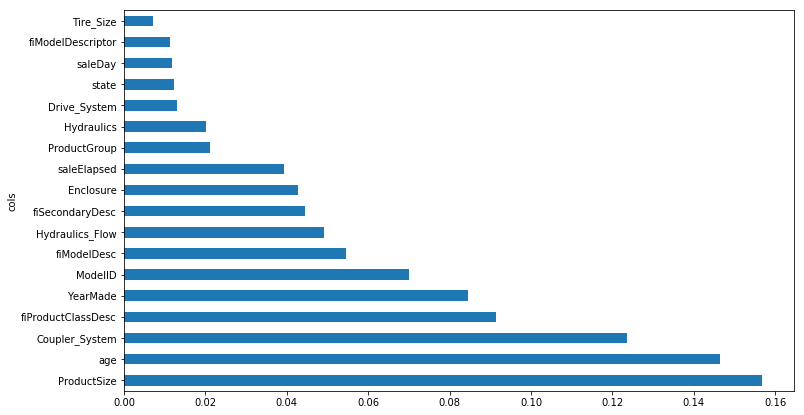

In [133]:
plot_fi(utils.rf_feat_importance(m, X_train));

## Final Model
We increase number of estimators now.

In [135]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, Y_train)
print_score(m)

Wall time: 2min 28s
[0.08024860655998314, 0.2116898789118956, 0.9865410919474613, 0.9199708575994372, 0.9145911504243915]
